In [1]:
from utils import extract_from_mnist, visualize_data
from train import prep_data,create_model,training_loop,eval_test,eval_train, plot_losses,visualize_weights_and_signs
from adv_attack import adv_attack,create_adv_test
from RBF_architecture import ShallowRBF, RbfNet2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from ADV_generalize import adv_attack, test_Maxout, training_loop_Maxout, eval_test_Maxout

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import LabelEncoder
from maxout import CustomMaxout

In [2]:
# Load the MNIST dataset
mnist = fetch_openml('mnist_784')

# Convert labels to integers
mnist.target = mnist.target.astype(int)

data = pd.DataFrame(data=mnist.data, columns=mnist.feature_names)
data['target'] = mnist.target

data = data.sample(n=20000, random_state=42)

# Reset the index of the filtered dataset
data = data.reset_index(drop=True)

# Print the shape of the filtered dataset
print("Filtered dataset shape:", data.shape)
print("Labels:", data['target'])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/var/folders/91/hvhdt2vj68l460f4fv_t0k0h0000gn/T/ipykernel_48634/3691792284.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['target'] = mnist.target


Filtered dataset shape: (20000, 785)
Labels: 0        8
1        4
2        8
3        7
4        7
        ..
19995    8
19996    3
19997    1
19998    7
19999    6
Name: target, Length: 20000, dtype: int64


In [3]:
# Assuming y is your target labels
y = data['target'].values

# Normalize the data
data_normalized = data.iloc[:, :-1].values / 255.0

# Convert data to PyTorch tensors
X_tensor = torch.tensor(data_normalized, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Split the data into training and testing sets
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
num_classes = len(set(y))
print("Unique classes in target labels:", num_classes)

Unique classes in target labels: 10


## On vire les classes autres que 4 pour le set de Test

In [4]:
List_arg_not4 = [i for i in range(y_test_tensor.shape[0]) if y_test_tensor[i] != 4]

X_test_tensor = torch.tensor(np.delete(X_test_tensor, List_arg_not4, axis=0), dtype=torch.float32)
y_test_tensor = torch.tensor(np.delete(y_test_tensor, List_arg_not4), dtype=torch.long)
print(X_test_tensor.shape)
print(y_test_tensor.shape)
anna_X_test_tensor = X_test_tensor[0,:]
anna_y_test_tensor = torch.tensor([4], dtype=torch.long)

print(anna_X_test_tensor.shape)
print(anna_y_test_tensor.shape)

torch.Size([363, 784])
torch.Size([363])
torch.Size([784])
torch.Size([1])


/var/folders/91/hvhdt2vj68l460f4fv_t0k0h0000gn/T/ipykernel_48634/1216468907.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(np.delete(X_test_tensor, List_arg_not4, axis=0), dtype=torch.float32)
/var/folders/91/hvhdt2vj68l460f4fv_t0k0h0000gn/T/ipykernel_48634/1216468907.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(np.delete(y_test_tensor, List_arg_not4), dtype=torch.long)


In [5]:
# Hyperparameters

batch_size = 128
n_epochs = 100
lr = 0.001

In [6]:
training_dataloader = DataLoader(X_train_tensor, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(X_test_tensor, batch_size=batch_size, shuffle=True)

In [8]:
# Define the Maxout layer
# Maxout Layer
class MaxoutLayer(nn.Module):
    def __init__(self, input_size, output_size, num_pieces=2):
        super(MaxoutLayer, self).__init__()
        self.fc = nn.Linear(input_size, output_size * num_pieces)
        self.num_pieces = num_pieces

    def forward(self, x):
        x = self.fc(x)
        x, _ = x.view(x.size(0), -1, self.num_pieces).max(-1)
        return x

# Maxout Network with Softmax Layer
class MaxoutNetworkWithSoftmax(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MaxoutNetworkWithSoftmax, self).__init__()
        self.layer1 = MaxoutLayer(input_size, 512)
        self.layer2 = MaxoutLayer(512, 256)
        self.softmax = nn.Softmax(dim=1)
        self.output_layer = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.layer1(x))
        x_arg = torch.relu(self.layer2(x))
        x = self.softmax(x_arg)
        logits = self.output_layer(x)
        return logits, x_arg

In [9]:
# Fonction de perte standard
def loss_fn(model, x, y):
    output = model(x)
    return F.cross_entropy(output, y)

# Fonction de perte adversariale
def adversarial_loss_fn(model, x, y, epsilon, alpha):
    # Calcul de la perte standard
    standard_loss = loss_fn(model, x, y)
    
    # Génération de l'exemple adverse
    x_adv = x + epsilon * torch.sign(torch.autograd.grad(standard_loss, x, create_graph=True)[0])
    
    # Calcul de la perte sur l'exemple adverse
    adversarial_loss = loss_fn(model, x_adv, y)
    
    # Combinaison des deux pertes
    return alpha * standard_loss + (1 - alpha) * adversarial_loss

In [10]:
input_size = 784
num_classes = 10
device = torch.device("cpu")

# Define the model
model = MaxoutNetworkWithSoftmax(input_size, num_classes)

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the loss function
criterion = nn.CrossEntropyLoss()

training_loss ,model_trained = training_loop_Maxout(optimizer, model, criterion, X_train_tensor, y_train_tensor,num_epochs=n_epochs,batch_size=batch_size)

Epoch [1/100], Loss: 2.0458
Epoch [2/100], Loss: 1.8439
Epoch [3/100], Loss: 1.6555
Epoch [4/100], Loss: 1.5171
Epoch [5/100], Loss: 1.3895
Epoch [6/100], Loss: 1.2300
Epoch [7/100], Loss: 1.1323
Epoch [8/100], Loss: 1.0604
Epoch [9/100], Loss: 0.9729
Epoch [10/100], Loss: 0.8865
Epoch [11/100], Loss: 0.8051
Epoch [12/100], Loss: 0.8179
Epoch [13/100], Loss: 0.7306
Epoch [14/100], Loss: 0.6989
Epoch [15/100], Loss: 0.7272
Epoch [16/100], Loss: 0.7439
Epoch [17/100], Loss: 0.5960
Epoch [18/100], Loss: 0.6398
Epoch [19/100], Loss: 0.5846
Epoch [20/100], Loss: 0.5489
Epoch [21/100], Loss: 0.5997
Epoch [22/100], Loss: 0.5712
Epoch [23/100], Loss: 0.5282
Epoch [24/100], Loss: 0.5304
Epoch [25/100], Loss: 0.6182
Epoch [26/100], Loss: 0.5456
Epoch [27/100], Loss: 0.4979
Epoch [28/100], Loss: 0.5530
Epoch [29/100], Loss: 0.5013
Epoch [30/100], Loss: 0.4894
Epoch [31/100], Loss: 0.4842
Epoch [32/100], Loss: 0.4800
Epoch [33/100], Loss: 0.4804
Epoch [34/100], Loss: 0.4837
Epoch [35/100], Loss: 0

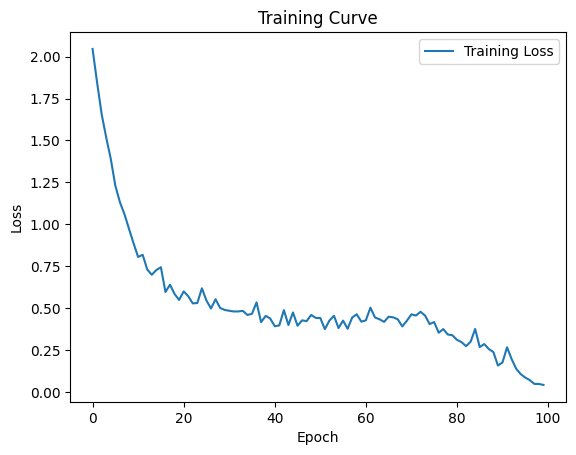

In [11]:
plot_losses(training_loss)

In [12]:
eval_test_Maxout(X_test_tensor,y_test_tensor,model)

Accuracy: 94.77%
Mean Confidence for All Examples: 0.9857
Mean Confidence for Incorrect Predictions: 0.8641


In [ ]:
test(model2, device, test_loader, 1)